# **2021 Regression Data**

In [2]:
#run this to install the package
%pip install CFEDemands
%pip install matplotlib
%pip install xarray
%pip install ConsumerDemands
%pip install eep153-tools
%pip install Cython>=3.0.10
%pip install 'setuptools-scm[toml]>=8.0.0,<9.0.0'
!pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
import numpy as np
from eep153_tools.sheets import read_sheets

In [7]:
US_Data = 'https://docs.google.com/spreadsheets/d/1OWluIYUGkmR6iFgSzJJa2ikEqqMT6BHbsKZyip236HU/edit?gid=2014531635#gid=2014531635'

In [8]:
# Step 1: Load food expenditure data
x_orig = read_sheets(US_Data,sheet='Food Expenditures 2021')

# Map food codes (j) to food names
# (Assumes each food code has only one food_name)
food_map = x_orig[['j', 'food_name']].drop_duplicates().set_index('j')['food_name']
x_orig['j'] = x_orig['j'].map(food_map)

# Now drop the original 'food_name' column (optional, since it's in 'j' now)
x_orig.drop(columns=['food_name'], inplace=True)

# Set index with food_name as j
x = x_orig.set_index(['i', 't', 'm', 'j'])

# Sum duplicate rows (e.g., same household and food appearing multiple times)
x = x.groupby(level=['i', 't', 'm', 'j']).sum()

# Replace zeros and take logs
x = x.replace(0, np.nan)
y = np.log(x.squeeze())

# Quick check
print("Shape of y:", y.shape)
y.head()


Shape of y: (141077,)


i       t     m    j                                                           
130378  2021  USA  Caesar dressing                                                 1.589235
                   Cheese, parmesan, dry grated                                    0.732368
                   Chicken, ns as to part and cooking method, ns as to skin eat    5.136386
                   Chicken, ns as to part and cooking method, skin not eaten       5.136386
                   Coffee, brewed                                                  6.396930
Name: grams, dtype: float64

In [9]:
# Load household characteristics
d = read_sheets(US_Data, sheet="Household Characteristics 2021")

# Optional: check what variables are available
print(d.columns)

# Clean and create covariates
d["sex"] = d["sex"].map({"Female": 1, "Male": 0})  # Map to binary
d["log_household"] = np.log(d["HH_size"])

# Keep only needed columns
d = d[["i", "t", "m", "sex", "log_household"]]

# Drop rows where log_household couldn't be computed
d = d.replace(np.nan, 0)
d = d[d["log_household"] > 0]

# Set index to match y
d = d.set_index(["i", "t", "m"])

# Preview
print("Shape of d:", d.shape)
d.head()

Index(['i', 't', 'm', 'age', 'sex', 'HH_size'], dtype='object')
Shape of d: (10017, 2)


,,,sex,log_household
i,t,m,,
130378,2021,USA,0,1.386294
130379,2021,USA,0,0.693147
130380,2021,USA,1,1.945910
130381,2021,USA,1,0.693147
130382,2021,USA,0,1.386294


In [10]:
# Step 3.1: Top 30 most common foods
food_counts = y.groupby('j').count()
top_foods = food_counts.sort_values(ascending=False).head(350).index
y_filtered = y[y.index.get_level_values('j').isin(top_foods)]

# Step 3.2: Random sample of 500 households
sample_ids = y_filtered.index.get_level_values('i').unique().to_series().sample(1750, random_state=42)

# Filter y and d to match
y_sample = y_filtered[y_filtered.index.get_level_values('i').isin(sample_ids)]
d_sample = d[d.index.get_level_values('i').isin(sample_ids)]

# Final checks
print("Shape of y_sample:", y_sample.shape)
print("Shape of d_sample:", d_sample.shape)


Shape of y_sample: (22436,)
Shape of d_sample: (1425, 2)


In [11]:
# Step 3.1: Top 30 most common foods
food_counts = y.groupby('j').count()
top_foods = food_counts.sort_values(ascending=False).head(350).index
y_filtered = y[y.index.get_level_values('j').isin(top_foods)]

# Step 3.2: Random sample of 500 households
sample_ids = y_filtered.index.get_level_values('i').unique().to_series().sample(1750, random_state=42)

# Filter y and d to match
y_sample = y_filtered[y_filtered.index.get_level_values('i').isin(sample_ids)]
d_sample = d[d.index.get_level_values('i').isin(sample_ids)]

# Final checks
print("Shape of y_sample:", y_sample.shape)
print("Shape of d_sample:", d_sample.shape)


Shape of y_sample: (22436,)
Shape of d_sample: (1425, 2)


In [12]:
# Diagnostic check: how many foods and households?
num_foods = y_sample.index.get_level_values('j').nunique()
num_households = y_sample.index.get_level_values('i').nunique()

print(f"Foods in sample: {num_foods}")
print(f"Households in sample: {num_households}")
print(f"Rows in y_sample: {y_sample.shape[0]}")
print(f"Rows in d_sample: {d_sample.shape[0]}")

Foods in sample: 350
Households in sample: 1750
Rows in y_sample: 22436
Rows in d_sample: 1425


In [13]:
from cfe import Regression

# Run the regression
result = Regression(y=y_sample, d=d_sample, compute_se=False, rectify=False, min_obs=10, min_prop_items=0.002)

In [14]:
predicted = result.predicted_expenditures()
predicted.head()

i       t     m    j               
130390  2021  USA  Apple, raw          175.494555
                   Avocado, raw        245.410571
                   Banana, raw         126.740057
                   Blueberries, raw    120.102635
                   Butter, stick        10.783195
dtype: float64

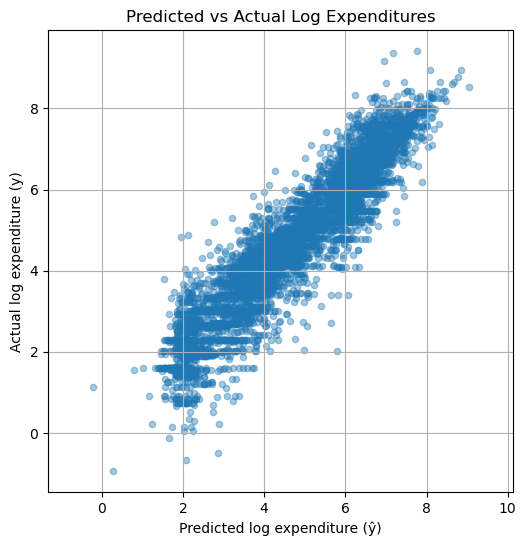

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

# Create DataFrame of actual vs predicted log expenditures
df = pd.DataFrame({
    'y': y_sample,
    'yhat': result.get_predicted_log_expenditures()
})

# Drop missing values (some may not match if data was trimmed)
df = df.dropna()

# Plot
df.plot.scatter(x='yhat', y='y', alpha=0.4, figsize=(6, 6))
plt.title("Predicted vs Actual Log Expenditures")
plt.xlabel("Predicted log expenditure (ŷ)")
plt.ylabel("Actual log expenditure (y)")
plt.grid(True)
plt.axis("equal")  # force square axes
plt.show()